<a href="https://colab.research.google.com/github/ehtisham-Fazal/ACP_SRC/blob/main/ACP_SRC_comibned_740%26240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os, re, gc
import numpy as np
import pandas as pd
from random import sample

## Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras import metrics
from keras import optimizers
from keras.utils.np_utils import to_categorical

import numpy.linalg as LA
from sklearn.model_selection import train_test_split

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score

## utilities
from matplotlib import pyplot as plt
!pip install wget
import wget


## pre-processing
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import KernelPCA
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE, KMeansSMOTE, BorderlineSMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=739576a2951426152cb0022cc168fa180b9f8964c07d41d56d0ca862892ba063
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
file1_path = 'https://raw.githubusercontent.com/NLPrinceton/sparse_recovery/master/solvers.py'
wget.download(file1_path, 'solvers.py')
from solvers import *
dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp240.txt'
wget.download(dataset_path, 'acp240.txt')
dataset_path='https://raw.githubusercontent.com/haichengyi/ACP-DL/master/acp740.txt'
wget.download(dataset_path, 'acp740.txt')

'acp740 (1).txt'

In [4]:
def prepare_feature_acp740():
    path = r"acp740.txt"
    new_list=[]
    seq_list=[]
    label = []
    lis = []
    lx=[]
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open(path, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]            
                proteinName = values[0]
                proteinName_1=proteinName.split("_")
                new_list.append(proteinName_1[0])              
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                seq_list.append(seq)
        for i, item in enumerate(new_list):
            lis.append([item, seq_list[i]])
        for i in lis:
            if len(i[1])>60:
                x=([i[0],i[1][0:60]])
                lx.append(x)
            else:
                lx.append(i)        
    return lx 
 



In [5]:
def prepare_feature_acp240():
    path = r"acp240.txt"
    new_list=[]
    seq_list=[]
    label = []
    lis = []
    """ to check the len of sequence below lx is used"""
    lx=[]
    interaction_pair = {}
    RNA_seq_dict = {}
    protein_seq_dict = {}
    protein_index = 0
    with open(path, 'r') as fp:
        for line in fp:
            if line[0] == '>':
                values = line[1:].strip().split('|')
                label_temp = values[1]            
                proteinName = values[0]
                proteinName_1=proteinName.split("_")
                new_list.append(proteinName_1[0])
                if label_temp == '1':
                    label.append(1)
                else:
                    label.append(0)
            else:
                seq = line[:-1]
                seq_list.append(seq)
        for i, item in enumerate(new_list):
            lis.append([item, seq_list[i]])
        for i in lis:
            if len(i[1])>60:
                x=([i[0],i[1][0:60]])
                lx.append(x)
            else:
                lx.append(i)
        
    return lx 

In [6]:
def yoden_index(y, y_pred):
  epsilon = 1e-30
  tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
  j = (tp/(tp + fn + epsilon)) + (tn/(tn+fp + epsilon)) - 1
  return j

def pmeasure(y, y_pred):
    epsilon = 1e-30
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    sensitivity = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    f1score = (2 * tp) / (2 * tp + fp + fn + epsilon)
    return ({'Sensitivity': sensitivity, 'Specificity': specificity, 'F1-Score': f1score})
    
def Calculate_Stats(y_actual,y_pred):
  acc = accuracy_score(y_actual, y_pred)
  sen = pmeasure(y_actual, y_pred)['Sensitivity']
  spe = pmeasure(y_actual, y_pred)['Specificity']
  f1 = pmeasure(y_actual, y_pred)['F1-Score']
  mcc = matthews_corrcoef(y_actual, y_pred)
  bacc = balanced_accuracy_score(y_actual, y_pred)
  yi = yoden_index(y_actual, y_pred)
  return acc, sen, spe, f1, mcc, bacc, yi

In [7]:
def Test_SRC(A,delta_y,DATA,LABEL,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=False, tol=1E-4, niter=100, biter=32):
  LABEL_PRED = []
  count = 0
  for ind in range(0,DATA.shape[1]):
    b = DATA[:,ind]
    if(solver=='BP'):     
      x = BasisPursuit(A, b, x0=x0, ATinvAAT=ATinvAAT, positive=positive, tol=tol, niter=niter, biter=biter)
    elif(solver=='MP'):      
      x = MatchingPursuit(A, b, tol=tol, nnz=nnz, positive=positive)
 
    label_out = delta_rule(A,delta_y,x,b)
    if (verbose):
      check = label_out==LABEL[ind]
      if (check):
        count = count + 1
      accuracy = 100*count/(ind+1)
      print(ind+1, count, accuracy, LABEL[ind], label_out, check)
    LABEL_PRED.append(label_out)

  return np.array(LABEL_PRED)

In [8]:
def delta_rule(A,delta_y,x,b):
  delta1 = 0*x
  delta2 = 0*x
  delta1[delta_y==1]=x[delta_y==1]
  delta2[delta_y==0]=x[delta_y==0]
  y1 = np.matmul(A,delta1)
  y2 = np.matmul(A,delta2)
  r1 = np.linalg.norm(y1-b)
  r2 = np.linalg.norm(y2-b)

  if(r1<r2):
    label = 1
  else:
    label = 0

  return label


In [9]:
def Convert_Seq2CKSAAP(train_seq, gap=8):
  cksaapfea = []
  seq_label = []
  for sseq in train_seq:
    temp= CKSAAP([sseq], gap=8)
    cksaapfea.append(temp[1][1:])
    seq_label.append(sseq[0])

  x = np.array(cksaapfea)
  y = np.array(seq_label)
  y[y=='ACP']=1
  y[y=='non-ACP']=0
  y = to_categorical(y)
  print('num pos:', sum(y[:,0]==1), 'num neg:', sum(y[:,0]==0))
  return x,y

def minSequenceLength(fastas):
    minLen = 10000
    for i in fastas:
        if minLen > len(i[1]):
            minLen = len(i[1])
    return minLen

def CKSAAP(fastas, gap=5, **kw):
    if gap < 0:
        print('Error: the gap should be equal or greater than zero' + '\n\n')
        return 0

    if minSequenceLength(fastas) < gap+2:
        print('Error: all the sequence length should be larger than the (gap value) + 2 = ' + str(gap+2) + '\n' + 'Current sequence length ='  + str(minSequenceLength(fastas)) + '\n\n')
        return 0

    AA = 'ACDEFGHIKLMNPQRSTVWY'
    encodings = []
    aaPairs = []
    for aa1 in AA:
        for aa2 in AA:
            aaPairs.append(aa1 + aa2)
    header = ['#']
    for g in range(gap+1):
        for aa in aaPairs:
            header.append(aa + '.gap' + str(g))
    encodings.append(header)
    for i in fastas:
        name, sequence = i[0], i[1]
        code = [name]
        for g in range(gap+1):
            myDict = {}
            for pair in aaPairs:
                myDict[pair] = 0
            sum = 0
            for index1 in range(len(sequence)):
                index2 = index1 + g + 1
                if index1 < len(sequence) and index2 < len(sequence) and sequence[index1] in AA and sequence[index2] in AA:
                    myDict[sequence[index1] + sequence[index2]] = myDict[sequence[index1] + sequence[index2]] + 1
                    sum = sum + 1
            for pair in aaPairs:
                code.append(myDict[pair] / sum)
        encodings.append(code)
    return encodings

num pos: 475 num neg: 505
num pos train: 380 num neg train: 404
Fold #  1
After Resampling 
 num pos train: 404 num neg train: 404
0.8367346938775511 0.8315789473684211 0.8415841584158416 0.8315789473684211 0.6731631057842626 0.8365815528921313 0.6731631057842626
num pos train: 380 num neg train: 404
Fold #  2
After Resampling 
 num pos train: 404 num neg train: 404
0.75 0.7473684210526316 0.7524752475247525 0.743455497382199 0.49971348400203436 0.749921834288692 0.49984366857738394
num pos train: 380 num neg train: 404
Fold #  3
After Resampling 
 num pos train: 404 num neg train: 404
0.8571428571428571 0.8 0.9108910891089109 0.8444444444444444 0.716893442298939 0.8554455445544555 0.7108910891089111
num pos train: 380 num neg train: 404
Fold #  4
After Resampling 
 num pos train: 404 num neg train: 404
0.7704081632653061 0.7684210526315789 0.7722772277227723 0.7643979057591623 0.5405574551715083 0.7703491401771756 0.5406982803543512
num pos train: 380 num neg train: 404
Fold #  5
Afte

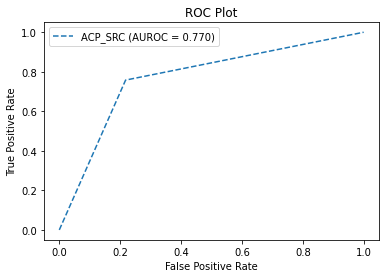

In [10]:
  ## Perform Monte-Carlos Simulations for [num_Trials]# of independent Trials
from sklearn.model_selection import KFold, StratifiedKFold
gaps = 8
loop_ind = 0
stats = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
ALL_seq=prepare_feature_acp740() + prepare_feature_acp240()
simplefilter(action='ignore', category=FutureWarning)
[DataX, LabelY] = Convert_Seq2CKSAAP(ALL_seq, gap=8)     
for train_index, test_index in kf.split(DataX,np.argmax(LabelY,axis=1)):
    loop_ind = loop_ind + 1
    X_train, X_test = DataX[train_index], DataX[test_index]
    y_train, y_test = LabelY[train_index], LabelY[test_index]
    print('num pos train:', sum(y_train[:,0]==1), 'num neg train:', sum(y_train[:,0]==0))
    y_train = y_train[:,0]
    y_test=y_test[:,0]  

    print('Fold # ', loop_ind)
    ## pre-processing PCA
    normalizer = Normalizer().fit(X_train)  # fit does nothing
    X_train = normalizer.transform(X_train)
    X_test = normalizer.transform(X_test)
    oversampler = BorderlineSMOTE(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    print('After Resampling \n','num pos train:', sum(y_train==1), 'num neg train:', sum(y_train==0))   
    transformer = KernelPCA(n_components=100, kernel='poly') # 'linear', 'poly', 'rbf', ‘sigmoid’, ‘cosine’
    transformer.fit_transform(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)  
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
    y_test_pred = Test_SRC(X_train,y_train,X_test,y_test,solver='BP',verbose=0, x0=None, ATinvAAT=None, nnz=None, positive=True, tol=1E-4, niter=100, biter=32)
    t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(y_test,y_test_pred)    
    print(t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi)    
    stats.append([t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi])

print('Mean stats:', np.mean(stats,axis=0))
print('Std stats:', np.std(stats,axis=0))
x=np.mean(stats,axis=0)
print("B_ACC={}, MCC={}, Youden's_index={}".format(x[5],x[4],x[6]))
###AUC ROC CURVE
r_auc = roc_auc_score(y_test,y_test_pred)
r_fpr, r_tpr, _ = roc_curve(y_test,y_test_pred)
plt.plot(r_fpr, r_tpr, linestyle='--', label='ACP_SRC (AUROC = %0.3f)' % r_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()